In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.cuda.amp as amp
from torch.nn.parallel import DataParallel
from torch.utils.data.distributed import DistributedSampler
import multiprocessing
import torch.nn.functional as F

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Noto Sans CJK SC']  # 常见中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示异常

df = pd.read_excel(r'C:\Users\12919\Desktop\24能源经济\proj_data\Renewable-energy-generation-input-feature-variables-analysis\data_processed\wind_farms\Wind farm site 1 (Nominal capacity-99MW).xlsx',index_col=0,header=0)
# 归一化函数


def normalize(data, method='minmax', min_value=None, max_value=None):
    """
    多方法归一化函数
    
    参数:
    - data: 需要归一化的数组或数据框列
    - method: 归一化方法，可选['minmax', 'standard', 'log', 'log_minmax']
    - min_value: 最小值（可选）
    - max_value: 最大值（可选）
    
    返回:
    - 归一化后的数据
    - 用于反归一化的参数字典
    """
    params = {}
    
    if method == 'minmax':
        if min_value is None:
            min_value = data.min()
        if max_value is None:
            max_value = data.max()
        normalized_data = (data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    elif method == 'standard':
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
        normalized_data = pd.Series(normalized_data, index=data.index)  # 转换回Series
        params = {'mean': scaler.mean_, 'std': scaler.scale_}
        
    elif method == 'log':
        normalized_data = np.log1p(data)
        params = {'method': 'log'}
        
    elif method == 'log_minmax':
        # 先对数变换
        log_data = np.log1p(data)
        # 再归一化
        if min_value is None:
            min_value = log_data.min()
        if max_value is None:
            max_value = log_data.max()
        normalized_data = (log_data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return normalized_data, params

def denormalize(normalized_data, params, method='minmax'):
    """
    多方法反归一化函数
    
    参数:
    - normalized_data: 归一化后的数据
    - params: 归一化参数字典
    - method: 归一化方法，需要与normalize函数使用的方法相同
    
    返回:
    - 反归一化后的原始数据
    """
    if method == 'minmax':
        original_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        
    elif method == 'standard':
        original_data = normalized_data * params['std'] + params['mean']
        
    elif method == 'log':
        original_data = np.expm1(normalized_data)
        
    elif method == 'log_minmax':
        # 先反归一化
        log_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        # 再指数变换
        original_data = np.expm1(log_data)
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return original_data
    

In [5]:
# 初始数据量
original_count = len(df)
print(f"原始数据总量: {original_count} 条")

# ========================================================================
# 第一过滤阶段：去除0功率但风速>切入风速的记录
# ========================================================================
cut_in_speed = 3  # 单位：m/s

# 创建异常条件标识
condition_zero_power = (
    (df['Power (MW)'] == 0) & 
    (df['Wind speed - at the height of wheel hub (m/s)'] > cut_in_speed)
)

# 统计被过滤量
removed_zero_power = condition_zero_power.sum()
print(f"\n条件1过滤：零功率高风速异常 → 移除 {removed_zero_power} 条 ({removed_zero_power/original_count:.2%})")

# 应用第一阶段过滤
df_stage1 = df[~condition_zero_power]

# ========================================================================
# 第二过滤阶段：功率突变过滤
# ========================================================================
# 计算相邻功率差
power_diff = df_stage1['Power (MW)'].diff().abs()

# 创建初始突变标识（仅突变点本身）
initial_abnormal = power_diff > 45

# 扩展标识（包含突变点及前一个时间点）
mask_abnormal = initial_abnormal | initial_abnormal.shift(-1, fill_value=False)

# 统计被过滤量
removed_spike = mask_abnormal.sum()
print(f"条件2过滤：功率突变异常 → 移除 {removed_spike} 条 ({removed_spike/len(df_stage1):.2%})")

# 应用第二阶段过滤
df_final = df_stage1[~mask_abnormal]

# ========================================================================
# 最终统计报告
# ========================================================================
print("\n最终统计：")
print(f"总移除数据量: {removed_zero_power + removed_spike} 条")
print(f"剩余有效数据量: {len(df_final)} 条 ({len(df_final)/original_count:.2%})")

# 验证示例
print("\n过滤后数据示例：")
print(df_final.head())

原始数据总量: 70176 条

条件1过滤：零功率高风速异常 → 移除 148 条 (0.21%)
条件2过滤：功率突变异常 → 移除 42 条 (0.06%)

最终统计：
总移除数据量: 190 条
剩余有效数据量: 69986 条 (99.73%)

过滤后数据示例：
                            Wind speed at height of 10 meters (m/s)  \
Time(year-month-day h:m:s)                                            
2019-01-01 00:00:00                                           2.209   
2019-01-01 00:15:00                                           1.828   
2019-01-01 00:30:00                                           2.193   
2019-01-01 00:45:00                                           2.654   
2019-01-01 01:00:00                                           2.249   

                            Wind direction at height of 10 meters (˚)  \
Time(year-month-day h:m:s)                                              
2019-01-01 00:00:00                                            81.317   
2019-01-01 00:15:00                                            77.460   
2019-01-01 00:30:00                                            86.700  

In [6]:

from scipy import stats

import seaborn as sns

# 读取数据
df=df_final.copy()

# 定义检验函数
def normal_shapiro(data):
    stat, p = stats.shapiro(data)
    return {'test': 'Shapiro-Wilk (Normal)', 'statistic': stat, 'p_value': p}

def lognormal_shapiro(data):
    if (data <= 0).any():
        return {'test': 'Shapiro-Wilk (Log-Normal)', 'error': 'Data contains non-positive values'}
    log_data = np.log(data)
    stat, p = stats.shapiro(log_data)
    return {'test': 'Shapiro-Wilk (Log-Normal)', 'statistic': stat, 'p_value': p}

def ks_normal_test(data):
    loc = data.mean()
    scale = data.std()
    stat, p = stats.kstest(data, 'norm', args=(loc, scale))
    return {'test': 'KS (Normal)', 'statistic': stat, 'p_value': p}

def ad_normal_test(data):
    result = stats.anderson(data, dist='norm')
    critical_value = result.critical_values[2]  # 5% significance level
    is_rejected = result.statistic > critical_value
    return {
        'test': 'Anderson-Darling (Normal)',
        'statistic': result.statistic,
        'critical_value_5%': critical_value,
        'rejected': is_rejected
    }

def t_test(data, popmean=0):
    stat, p = stats.ttest_1samp(data, popmean=popmean)
    return {'test': 'T-Test (μ=0)', 'statistic': stat, 'p_value': p}

# 对每列进行分析和可视化
for column in df.columns:
    data = df[column].dropna().values
    if len(data) == 0:
        print(f"Column {column} has no valid data.")
        continue
    
    # 执行所有检验
    results = [
        normal_shapiro(data),
        lognormal_shapiro(data),
        ks_normal_test(data),
        ad_normal_test(data),
        t_test(data)
    ]
    print(f"Results for column {column}:")
    print(results)
    # # 创建可视化
    # plt.figure(figsize=(12, 7))
    # sns.histplot(data, kde=False, stat='density', label='Data Histogram')
    
    # # 生成理论分布曲线
    # x = np.linspace(data.min(), data.max(), 100)
    
    # # 正态分布曲线
    # loc, scale = data.mean(), data.std()
    # norm_pdf = stats.norm.pdf(x, loc=loc, scale=scale)
    # plt.plot(x, norm_pdf, 'r-', lw=2, label='Normal Distribution')
    
    # # 对数正态分布曲线（如果数据全为正）
    # if (data > 0).all():
    #     mu, sigma = np.log(data).mean(), np.log(data).std()
    #     lognorm_pdf = stats.lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    #     plt.plot(x, lognorm_pdf, 'g--', lw=2, label='Log-Normal Distribution')
    
    # plt.title(f'Distribution Fit and Test Results for {column}')
    # plt.xlabel('Value')
    # plt.ylabel('Density')
    
    # # 创建结果文本
    # text_content = []
    # for res in results:
    #     if 'error' in res:
    #         text_content.append(f"{res['test']}: {res['error']}")
    #     else:
    #         line = f"{res['test']}\nStat: {res['statistic']:.3f}"
    #         if 'p_value' in res:
    #             line += f", p-value: {res['p_value']:.3f}"
    #         if 'rejected' in res:
    #             line += f"\nRejected at 5%: {res['rejected']}"
    #         text_content.append(line)
    
    # plt.text(0.98, 0.75, '\n'.join(text_content),
    #          transform=plt.gca().transAxes,
    #          verticalalignment='top',
    #          horizontalalignment='right',
    #          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)


Results for column Wind speed at height of 10 meters (m/s):
[{'test': 'Shapiro-Wilk (Normal)', 'statistic': 0.9602784379347973, 'p_value': 1.3684258421044973e-81}, {'test': 'Shapiro-Wilk (Log-Normal)', 'error': 'Data contains non-positive values'}, {'test': 'KS (Normal)', 'statistic': 0.07777241285934999, 'p_value': 0.0}, {'test': 'Anderson-Darling (Normal)', 'statistic': 643.1479455198714, 'critical_value_5%': 0.787, 'rejected': True}, {'test': 'T-Test (μ=0)', 'statistic': 484.2750075886753, 'p_value': 0.0}]
Results for column Wind direction at height of 10 meters (˚):
[{'test': 'Shapiro-Wilk (Normal)', 'statistic': 0.8905508749178537, 'p_value': 7.990842502310883e-107}, {'test': 'Shapiro-Wilk (Log-Normal)', 'error': 'Data contains non-positive values'}, {'test': 'KS (Normal)', 'statistic': 0.17891077150053636, 'p_value': 0.0}, {'test': 'Anderson-Darling (Normal)', 'statistic': 2873.42407836605, 'critical_value_5%': 0.787, 'rejected': True}, {'test': 'T-Test (μ=0)', 'statistic': 800.1

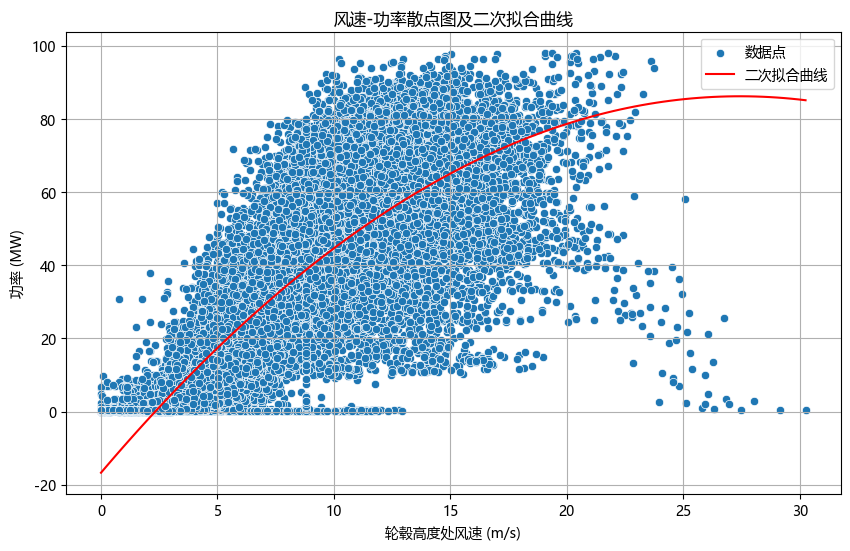

In [7]:
# 绘制风速-功率散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Wind speed - at the height of wheel hub (m/s)', y='Power (MW)', data=df, label='数据点')
plt.title('风速-功率散点图及二次拟合曲线')
plt.xlabel('轮毂高度处风速 (m/s)')
plt.ylabel('功率 (MW)')
plt.grid(True)

# 二次拟合
x = df['Wind speed - at the height of wheel hub (m/s)'].values
y = df['Power (MW)'].values

# 使用numpy进行二次多项式拟合
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# 生成拟合曲线的x值
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = polynomial(x_fit)

# 绘制拟合曲线
plt.plot(x_fit, y_fit, color='red', label='二次拟合曲线')
plt.legend()
plt.show()

正在对列 Wind speed at height of 10 meters (m/s) 进行检验...
正在对列 Wind direction at height of 10 meters (˚) 进行检验...
正在对列 Wind speed at height of 30 meters (m/s) 进行检验...
正在对列 Wind direction at height of 30 meters (˚) 进行检验...
正在对列 Wind speed at height of 50 meters (m/s) 进行检验...
正在对列 Wind direction at height of 50 meters (˚) 进行检验...


c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res =

正在对列 Wind speed - at the height of wheel hub (m/s) 进行检验...
正在对列 Wind speed - at the height of wheel hub (˚) 进行检验...
正在对列 Air temperature  (°C)  进行检验...
正在对列 Atmosphere (hpa) 进行检验...
正在对列 Relative humidity (%) 进行检验...
正在对列 Power (MW) 进行检验...


c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\12919\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 69986.
  res =

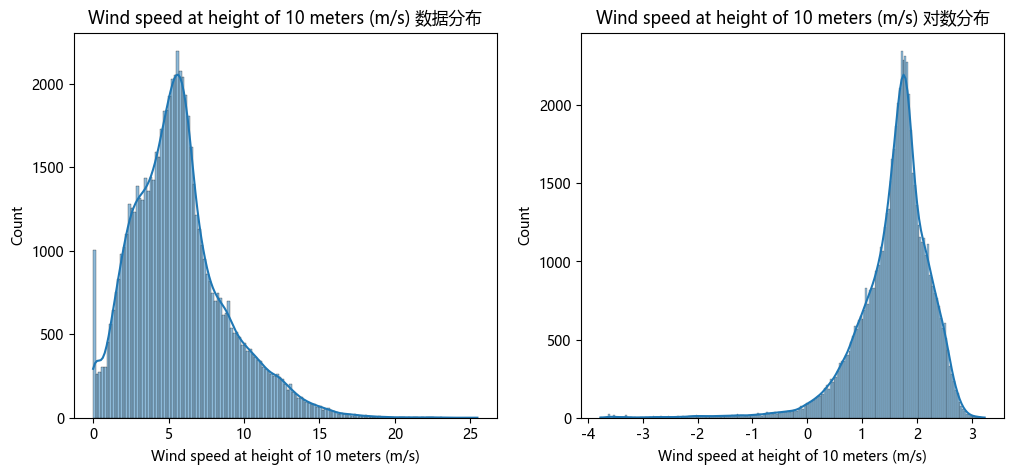

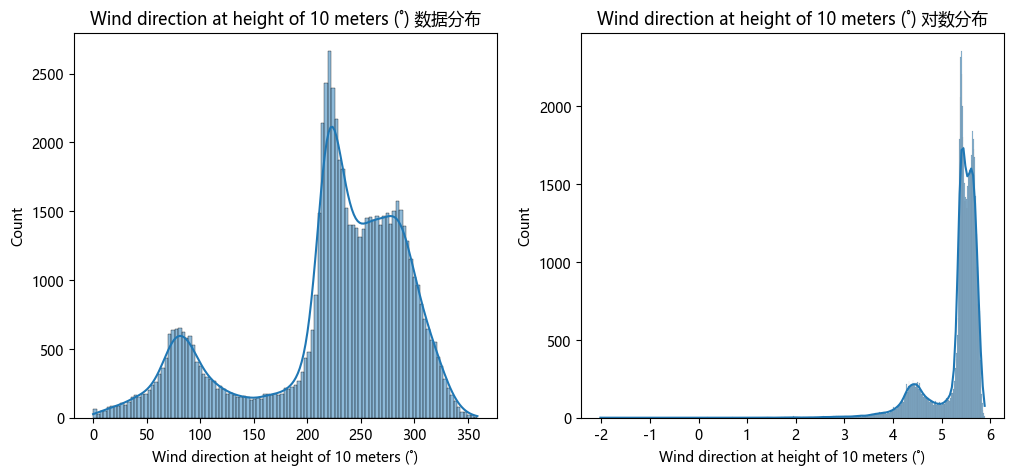

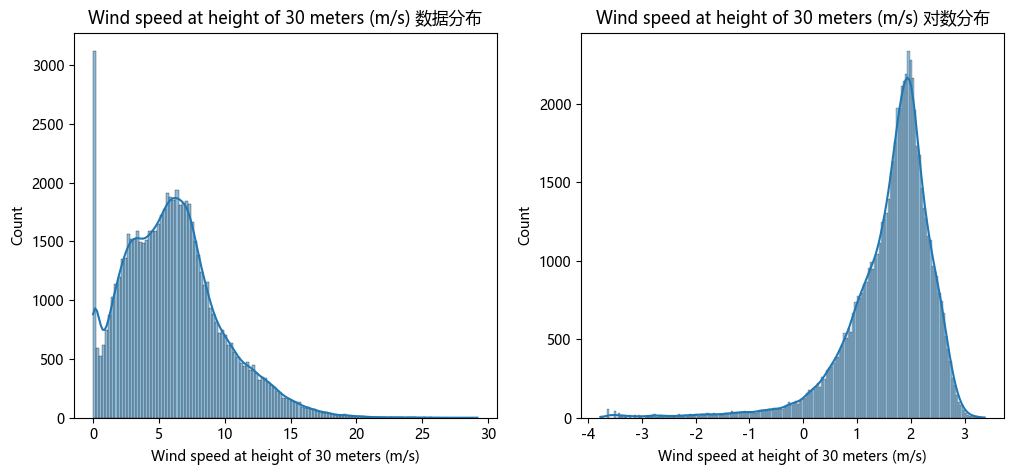

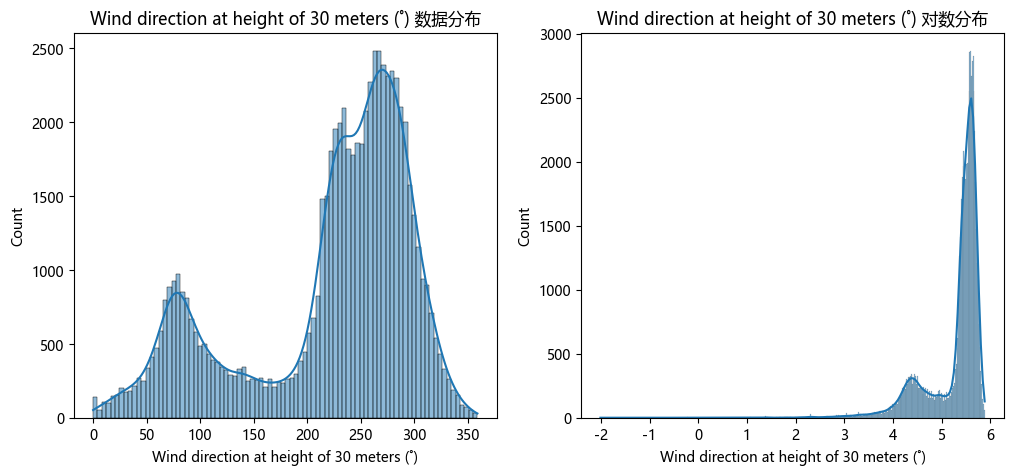

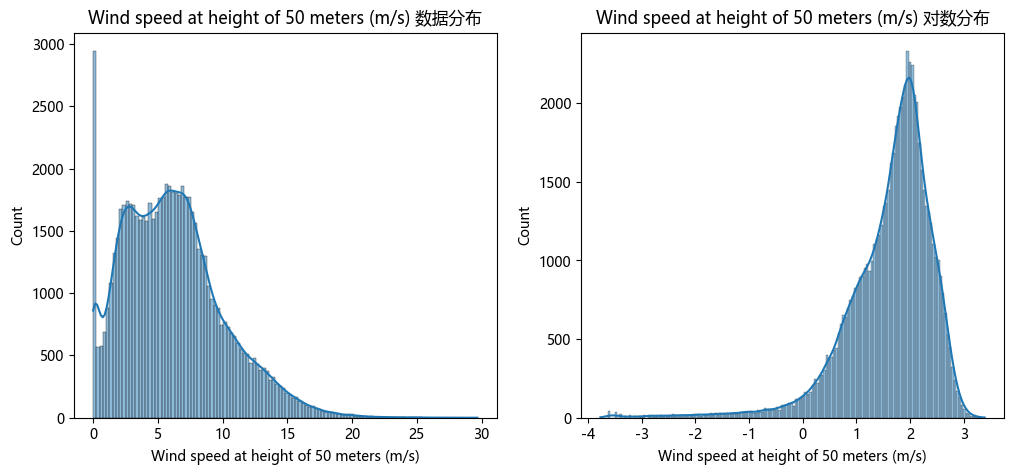

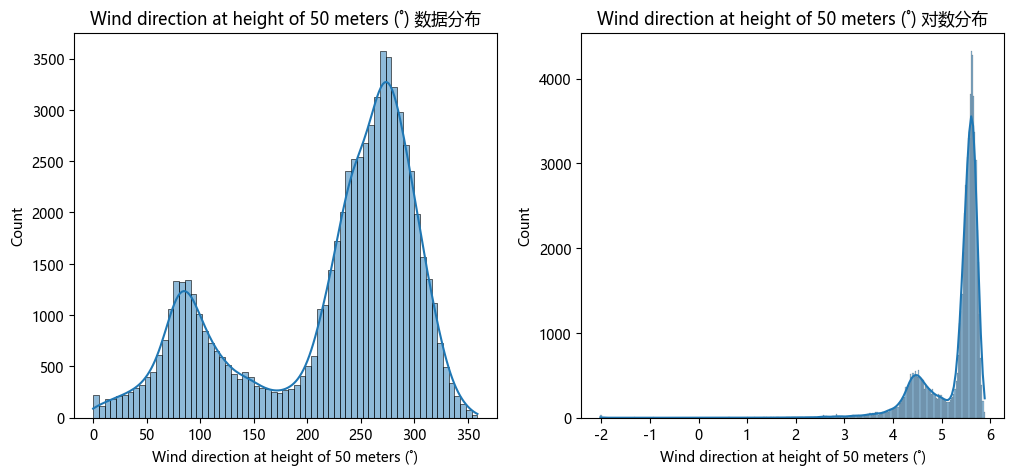

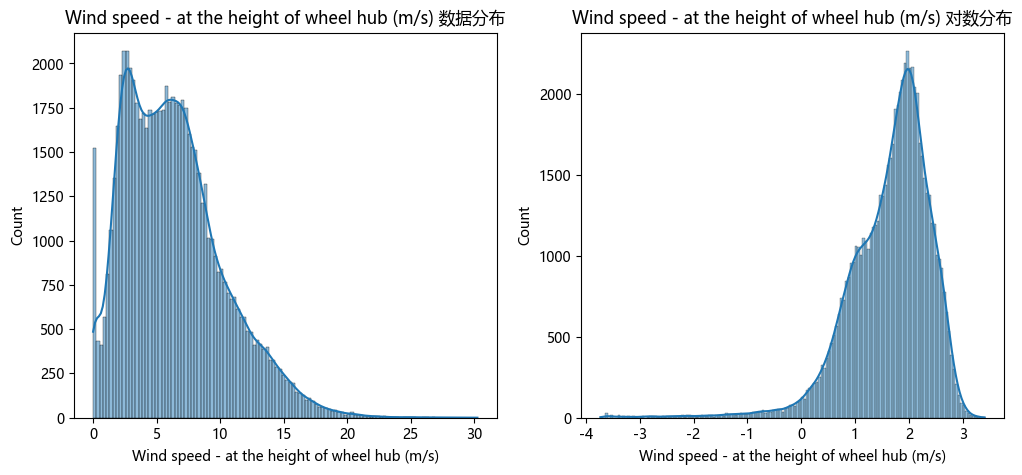

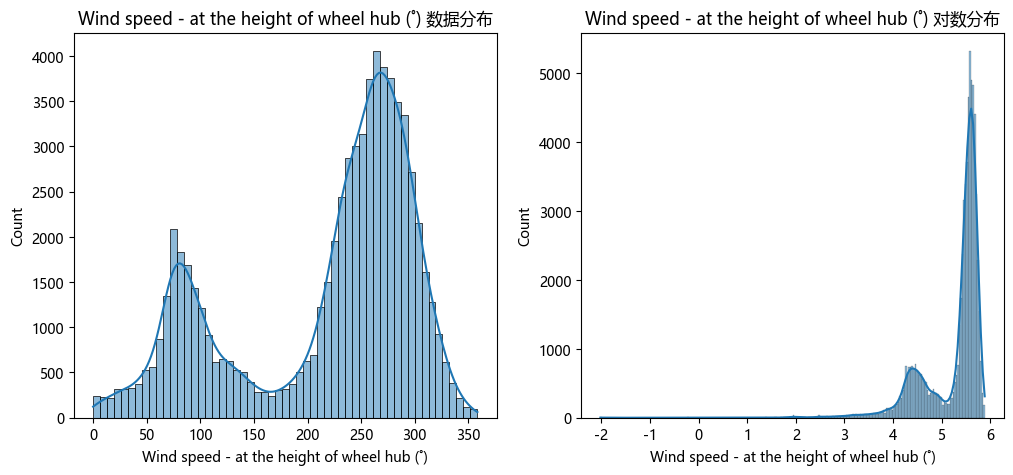

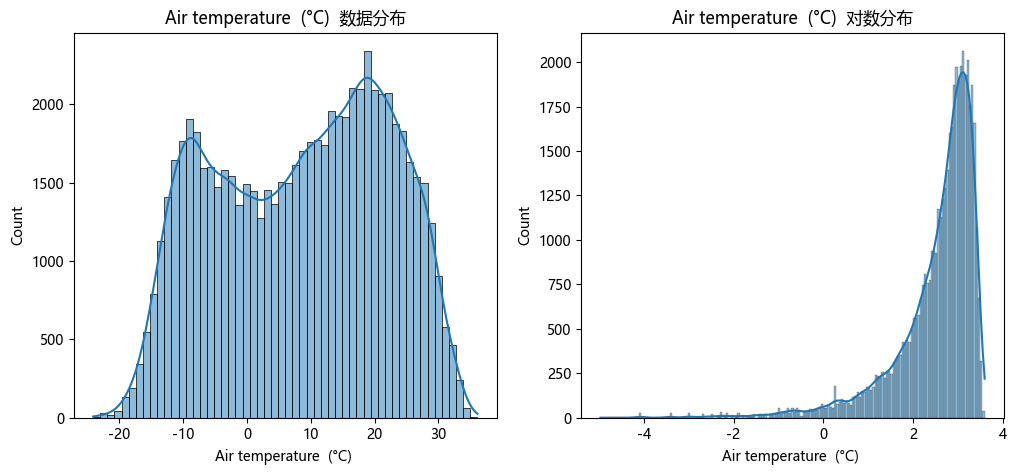

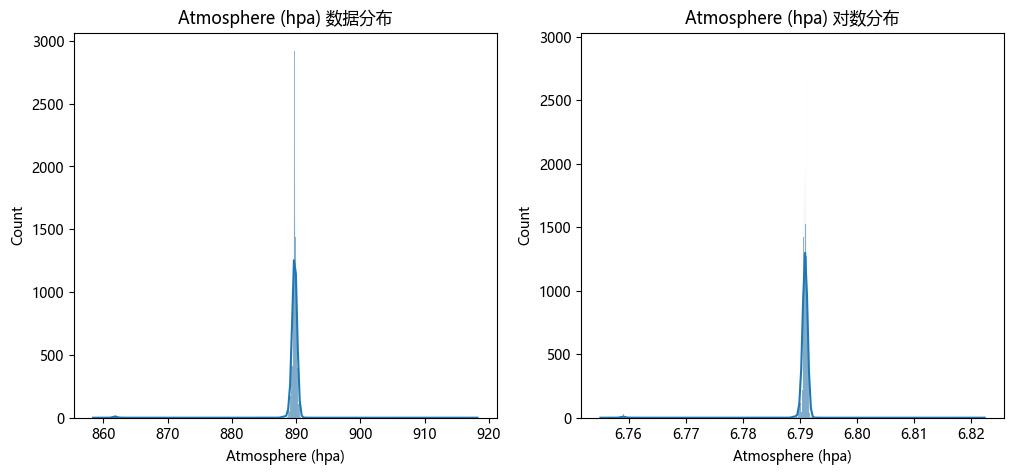

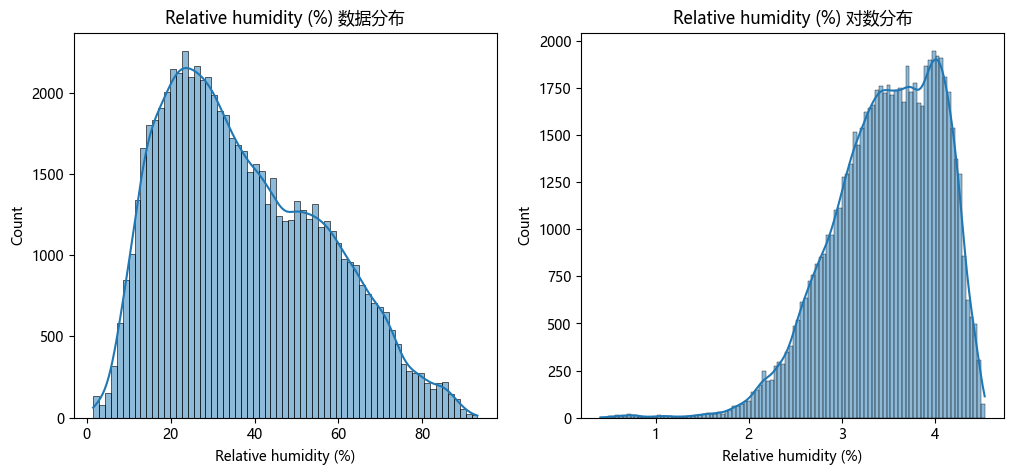

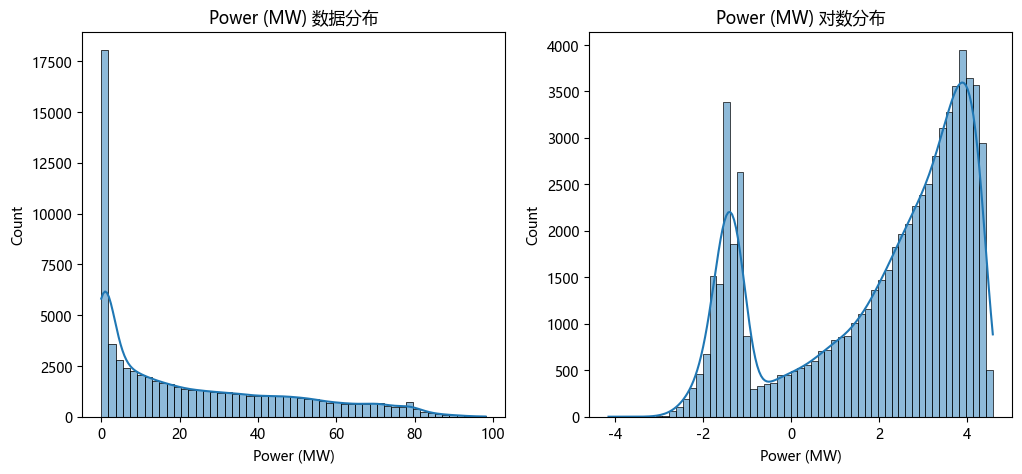

In [8]:
from scipy.stats import shapiro, normaltest, anderson, kstest, lognorm, chi2_contingency



# 定义检验函数
# 定义正态性检验函数
def normality_tests(column):
    # Shapiro-Wilk检验
    shapiro_stat, shapiro_p = shapiro(column)
    # Anderson-Darling检验
    anderson_stat, anderson_critical_values, anderson_significance_level = anderson(column, dist='norm')
    # Kolmogorov-Smirnov检验
    ks_stat, ks_p = kstest(column, 'norm')
    
    # 对数正态分布检验
    log_data = np.log(column[column > 0])  # lognorm检验要求所有值大于0
    lognorm_stat, lognorm_p = kstest(log_data, lognorm(s=1).cdf)
    
    return {
        'Shapiro-Wilk': {'statistic': shapiro_stat, 'p_value': shapiro_p},
        'Anderson-Darling': {'statistic': anderson_stat, 'critical_values': anderson_critical_values, 'significance_level': anderson_significance_level},
        'Kolmogorov-Smirnov': {'statistic': ks_stat, 'p_value': ks_p},
        'Log-Normal': {'statistic': lognorm_stat, 'p_value': lognorm_p}
    }

# 定义卡方检验函数
def chi_square_test(column, bins=10):
    # 对数据进行分箱
    observed, _ = pd.cut(column, bins=bins, retbins=True)
    # 计算每个分箱的频数
    observed_counts = observed.value_counts().sort_index()
    
    # 预期频数（假设数据均匀分布）
    expected_counts = pd.Series(len(column) / bins, index=observed_counts.index)
    
    # 计算卡方统计量和p值
    chi2_stat, chi2_p, dof, expected = chi2_contingency(pd.concat([observed_counts, expected_counts], axis=1).values)
    return {'statistic': chi2_stat, 'p_value': chi2_p, 'degrees_of_freedom': dof, 'expected': expected}

# 对每一列数据进行检验
results = []
for column in df.columns:
    print(f"正在对列 {column} 进行检验...")
    # 正态分布、对数正态分布、卡方检验
    normality = normality_tests(df[column])
    chi_square = chi_square_test(df[column])
    
    results.append({
        '列': column,
        'Shapiro-Wilk Statistic': normality['Shapiro-Wilk']['statistic'],
        'Shapiro-Wilk P-value': normality['Shapiro-Wilk']['p_value'],
        'Anderson-Darling Statistic': normality['Anderson-Darling']['statistic'],
        'Anderson-Darling Critical Values': ', '.join(map(str, normality['Anderson-Darling']['critical_values'])),
        'Anderson-Darling Significance Level': ', '.join(map(str, normality['Anderson-Darling']['significance_level'])),
        'Kolmogorov-Smirnov Statistic': normality['Kolmogorov-Smirnov']['statistic'],
        'Kolmogorov-Smirnov P-value': normality['Kolmogorov-Smirnov']['p_value'],
        'Log-Normal Statistic': normality['Log-Normal']['statistic'],
        'Log-Normal P-value': normality['Log-Normal']['p_value'],
        'Chi-Square Statistic': chi_square['statistic'],
        'Chi-Square P-value': chi_square['p_value'],
        'Degrees of Freedom': chi_square['degrees_of_freedom']
    })

# 将结果转换为DataFrame以便保存
results_df = pd.DataFrame(results)

# 保存结果到Excel文件
results_df.to_excel(r'C:\Users\12919\Desktop\24能源经济\code\fit_test_results.xlsx', index=False)

# 可视化结果（可选）
for column in df.columns:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} 数据分布')
    
    plt.subplot(1, 2, 2)
    sns.histplot(np.log(df[column][df[column] > 0]), kde=True)
    plt.title(f'{column} 对数分布')
    plt.show()